In [ ]:
%pip install progressbar xgboost matplotlib boto3 openpyxl tqdm hydroeval



# import the packages

In [1]:
# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this
import FigureGenerator


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from datetime import datetime, date
import pickle

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib


from progressbar import ProgressBar
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import hydroeval as he

import platform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# find the directory path for different OS systems

In [2]:
if platform.system() == 'Windows':
    onedrive_path = 'E:/OneDrive/OneDrive - The University of Alabama/10.material/01.data/usgs_data/'
    box_path = 'C:/Users/snaserneisary/Box/NWM-ML/'

elif platform.system() == 'Darwin':
    onedrive_path = '/Users/savalan/Library/CloudStorage/OneDrive-TheUniversityofAlabama/02.projects/03.ciroh/04.data/'
    box_path = '/Users/savalan/Library/CloudStorage/Box-Box/NWM-ML/Data/NWM/ut/'
    
elif platform.system() == 'Linux':
    path_01 = '/home/ec2-user/SageMaker/01.projects/01.ciroh_p8/NWM-ML/savalan/'

# functions 

In [3]:
#make some functions to easily change/evaluate our model(s)
def XGBoost_GridSearch(hyperparameters, modelname):
    #path = './Model/'+modelname+'_params.pkl'
    # create an xgboost regression model
    xgb1 = XGBRegressor()

    #set up the GridSearchCV function
    xgb_grid = GridSearchCV(xgb1,
                            hyperparameters,
                            cv = 3,
                            n_jobs = -1,
                            verbose=3
                           )

    #Run the GridSearch fit functtion
    xgb_grid.fit(x_train_scaled, y_train_scaled)

    print('The best hyperparameter three-fold cross validation score is: ')
    print(xgb_grid.best_score_)

    print(' ')
    print('The optimal hyper-parameters are: ')
    print(xgb_grid.best_params_)

    #save the model features
    joblib.dump(xgb_grid, path)

    return xgb_grid

def Model_Evaluation_Plots(DF, predictions):

# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1

    #add color options
    colors = ['blue', 'orange', 'red','green']


    # Add predictions to plot
    for pred in np.arange(0, len(predictions),1):
        ax.scatter(DF['flow_cfs'], DF[predictions[pred]],
                   c=colors[pred], alpha=0.35, label=predictions[pred])

     # Add some parameters.
    ax.set_title('Streamflow Predictions', fontsize=16)
    ax.set_xlabel('Observations (cfs)', fontsize=14)
    ax.set_ylabel('Predictions (cfs)', fontsize=14,)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(ymin, ymax)
    ax.legend(fontsize=14, loc='upper right')

    #Add a 1:1 prediction:observation plot
    ax.plot((0,ymax),(0,ymax), linestyle = '--', color  = 'red')

    plt.show()


#Define some key model performance metics: RMSE, PBias, MAE, MAPE
def RMSE(DF, predictions):
    R = []
    for pred in np.arange(0, len(predictions),1):
        rmse = mean_squared_error(DF['flow_cfs'], DF[predictions[pred]], squared=False)
        R.append(rmse)
        #print('RMSE for ', predictions[pred], ' is ', rmse, ' cfs')
    return R

def MAPE(DF, predictions):
    P =[]
    for pred in np.arange(0, len(predictions),1):
        mape = round(mean_absolute_percentage_error(DF['flow_cfs'], DF[predictions[pred]])*100, 2)
        P.append(mape)
        #print('Mean Absolute Percentage Error for ', predictions[pred], ' is ', mape, '%')
    return P

def PBias(DF, predictions):
    PB = []
    for pred in np.arange(0, len(predictions),1):
        pbias = he.evaluator(he.pbias,  DF[predictions[pred]], DF['flow_cfs'])
        pbias = round(pbias[0],2)
        PB.append(pbias)
        #print('Percentage Bias for ', predictions[pred], ' is ', pbias, '%')
    return PB    
  
def KGE(DF, predictions):
    KG = []
    for pred in np.arange(0, len(predictions),1):
        kge, r, alpha, beta = he.evaluator(he.kge,  DF[predictions[pred]], DF['flow_cfs'])
        kge = round(kge[0],2)
        KG.append(kge)
        #print('Kling-Glutz Efficiency for ', predictions[pred], ' is ', kge)
    return KG


In [5]:
raw_training_data = pd.read_csv(path_01 + '03.output/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,temperature_F,precipitation_in,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-13,45.356945,0.515038,0.857167,35.096,0.00000,0.0,7.70,60.0,73
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-14,49.750000,0.515038,0.857167,35.258,0.00000,0.0,7.45,62.0,74
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-15,52.483334,0.515038,0.857167,36.860,0.00000,0.0,7.35,65.0,75
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-16,60.296875,0.515038,0.857167,38.120,0.00000,0.0,7.25,63.0,76
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2012-03-17,68.876045,0.515038,0.857167,38.102,0.04698,0.0,6.85,65.0,77


In [6]:
raw_training_data_temp = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [7]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

raw_training_data_temp.drop(['precipitation_in', 'temperature_F', 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)



### Remove headwater stations!!!!!!!

In [8]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
raw_training_data_temp = raw_training_data_temp[~raw_training_data_temp['station_id'].isin(headwater_stations)]

In [9]:
raw_training_data_temp.datetime = pd.to_datetime(raw_training_data_temp.datetime)

raw_training_data_temp.head()


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
789,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-01,1488.4375,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-02,1282.1875,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-03,1269.4791,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-04,1551.5625,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-05,1490.5209,0.515038,0.857167,89.026144,13.221429,1541.0,65


In [10]:
x_train_temp = raw_training_data_temp[raw_training_data_temp.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp.head()

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
789,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,89.026144,13.221429,1541.0,65


In [11]:
xx_1, xx, yy_1, yy= train_test_split(x_train_temp, y_train_temp, test_size=0.1, random_state=1)

x_train_temp = pd.concat([xx_1.reset_index(drop=True), xx.reset_index(drop=True)])

y_train_temp = pd.concat([yy_1, yy])

y_train = y_train_temp.to_numpy()

x_train = x_train_temp.to_numpy()

scaler = MinMaxScaler()


x_train_scaled = scaler.fit_transform(x_train)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))


In [12]:
x_train_temp.head()

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
0,41.268552,-111.674100,137.0,0.72,0.0253,50.2,-0.998630,5.233596e-02,46.070423,0.0,46.0,319
1,40.605111,-111.314528,223.0,1.89,0.1200,24.0,-0.017452,-9.998477e-01,0.000000,0.0,193.0,220
2,41.136888,-111.832438,1620.0,2.31,0.4400,14.2,-0.017452,-9.998477e-01,61.506950,0.0,1040.0,217
3,40.922446,-111.607150,152.0,7.13,1.6500,42.3,1.000000,6.125740e-17,65.808081,2.7,163.0,137
4,41.268552,-111.674100,137.0,0.72,0.0253,50.2,0.484810,-8.746197e-01,72.802817,0.0,44.0,195


In [13]:
x_test_temp = raw_training_data_temp[raw_training_data_temp.datetime.dt.year == 2020]
x_test_temp.head()

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
1029,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-01,1642.3959,0.515038,0.857167,64.241830,14.914286,1012.0,61
1030,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-02,1724.2709,0.515038,0.857167,64.215686,15.142857,1011.0,62
1031,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-03,1751.2500,0.515038,0.857167,64.189542,15.135714,1010.0,63
1032,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-04,1675.4166,0.515038,0.857167,64.189542,15.135714,1009.0,64
1033,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-05,1697.8125,0.515038,0.857167,64.241830,15.085714,1008.0,65


In [14]:
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

In [19]:

#make some ranges of hyperparamter values of interest
hyperparameters = {
    'max_depth': range (2, 11, 1),
    'n_estimators': range(100, 2100, 200),
    'eta': [0.1, 0.01, 0.05]
}

#run he GridSearchCV function
parameters  = XGBoost_GridSearch(hyperparameters, f"./xgboost_models/xgb_params.pkl")



Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=100;, score=0.800 total time=   0.1s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=100;, score=0.804 total time=   0.1s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=100;, score=0.832 total time=   0.1s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=300;, score=0.845 total time=   0.3s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=300;, score=0.838 total time=   0.3s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=300;, score=0.868 total time=   0.3s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=500;, score=0.858 total time=   0.4s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=500;, score=0.851 total time=   0.4s
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=500;, score=0.882 total time=   0.4s
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=700;, score=0.866 total time=   0.6s
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=700;, score=0.860 total time=   0.6s
[C

In [34]:
parameters.best_params_

{'eta': 0.1, 'max_depth': 7, 'n_estimators': 1900}

In [20]:
#load parameters and train model on CV methods as the original model
parameters = joblib.load(f"./xgboost_models/xgb_params.pkl")
eta = parameters.best_params_['eta']
max_depth =parameters.best_params_['max_depth']
n_estimators = parameters.best_params_['n_estimators']

# create an xgboost regression model
model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=0.7, colsample_bytree=0.8)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, x_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)


#fit the model
print('Fitting the model')
model.fit(x_train_scaled, y_train_scaled)

print('Saving Model')
#adjust this to match changing models
pickle.dump(model, open(f"./xgboost_models/XGBmodel.pkl", "wb"))  

# Caculate model performance and force scores to be positive
print('Mean MAE: %.3f (%.3f)' % (abs(scores.mean()), scores.std()) )

Fitting the model
Saving Model
Mean MAE: 0.004 (0.000)


Text(0.5, 1.0, 'Feature Importance')

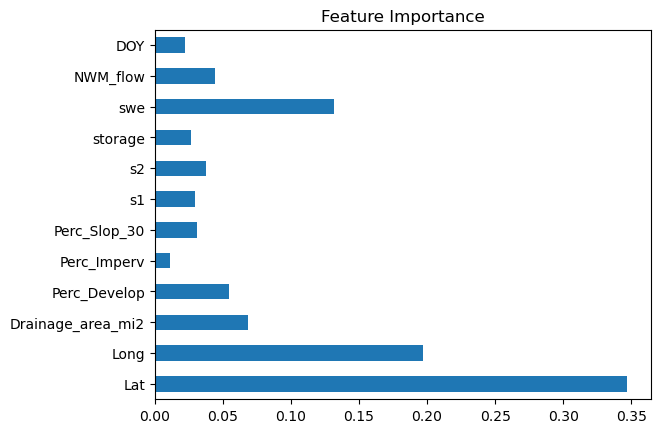

In [25]:


#First, we need to get the X dataframe column names to attach to the feature importance array
cols = x_train_temp.columns

#make a dataframe using columns and feature importance
FI = pd.DataFrame([model.feature_importances_], columns = cols)

#Make a barplot to visualize the relative importances
ax = FI.T.plot.barh()
ax.get_legend().remove()
plt.title('Feature Importance')


In [123]:
#put the model scores into a dataframe for comparison
mod = 'XGBoost'
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape", 'Obs_vol', 'NWM_vol', f"{mod}_vol",
        'NWM_vol_err', f"{mod}_vol_err", 'NWM_vol_Perc_diff', f"{mod}_vol_Perc_diff"]


EvalDF = pd.DataFrame(columns = cols)
SupplyEvalDF = pd.DataFrame(columns = supcols)

#get annual supply diffs
cfsday_AFday = 1.983

SitesDict = {}
model = pickle.load(open(f"./xgboost_models/XGBmodel.pkl", "rb"))

for station_number in station_index_list.drop_duplicates():
    #print(station_number)
    index = station_index_list == station_number


    X_test = x_test_temp_1[index]
    X_test_scaled = x_test_1_scaled[index]
    y_test = y_test_temp_1[index]

    # make a prediction
    y_pred_Hyp = model.predict(X_test_scaled)

    #scale the predictions back to streamflow in cfs and convert to pandas DataFrame
    y_pred_Hyp = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(y_pred_Hyp)),columns = ['XGBoost_flow'])

    y_pred_Hyp[y_pred_Hyp<0] = 0
    #Combine X_test, y_pred, and y_test DataFrames to evaluate the performance of the model
    #reset indexes
    #Dfs = [y_pred_Hyp, y_pred, y_test, X_test]
    Dfs = [y_pred_Hyp, y_test, X_test]
    for df in Dfs:
        df.reset_index(drop = True, inplace = True)

    #merge
    nwm_test = pd.concat(Dfs, axis=1)
    #save predictions, need to convert to NHDPlus reach - Need to add Datetime column and relable flow predictions
    #make daterange
    dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
    nwm_test['Datetime'] = dates
    #put columns in correct order
    cols = ['Datetime', 'XGBoost_flow']
    nwm_test = nwm_test[cols]
    
    #get reach id for model eval
    nhdreach = utils.crosswalk(usgs_site_codes=station_number)
    nhdreach = nhdreach['nwm_feature_id'].iloc[0]
    
    #save predictions
    mod = 'XGBoost'
    save_path = f"./Predictions/Hindcast/{mod}/{mod}_{nhdreach}.csv"
    nwm_test.to_csv(save_path)
    
      # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    
    prediction_columns = [ 'NWM_flow', 'XGBoost_flow']

    #plot the predictions
   # Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get Performance Metrics from the model
    rmse = RMSE(Eval_DF_mine, prediction_columns)
    mape = MAPE(Eval_DF_mine, prediction_columns)
    pbias = PBias(Eval_DF_mine, prediction_columns)
    kge = KGE(Eval_DF_mine, prediction_columns)
    
    #Get Volumetric values
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True, drop =True)
    flowcols = [f"{mod}_flow", 'flow_cfs', 'NWM_flow']
    SupplyEval = Eval_DF_mine[flowcols].copy()
    SupplyEval = SupplyEval*cfsday_AFday
    #set up cumulative monthly values
    SupplyEval['Year'] = SupplyEval.index.year

    for site in flowcols:
        SupplyEval[site] = SupplyEval.groupby(['Year'])[site].cumsum()  

    EOY_mod_vol_af = SupplyEval[f"{mod}_flow"].iloc[-1]
    EOY_obs_vol_af = SupplyEval["flow_cfs"].iloc[-1]
    EOY_nwm_vol_af = SupplyEval[f"NWM_flow"].iloc[-1]
    NWM_vol_diff_af = EOY_nwm_vol_af - EOY_obs_vol_af
    Mod_vol_diff_af = EOY_mod_vol_af - EOY_obs_vol_af
    NWM_Perc_diff = (NWM_vol_diff_af/EOY_obs_vol_af)*100
    Mod_Perc_diff = (Mod_vol_diff_af/EOY_obs_vol_af)*100
    
     #Get Performance Metrics from the model
    Srmse = RMSE(SupplyEval, prediction_columns)
    Smape = MAPE(SupplyEval, prediction_columns)
    Spbias = PBias(SupplyEval, prediction_columns)
    Skge = KGE(SupplyEval, prediction_columns)
    
    
    #save model performance
    sitestats = [station_number, nhdreach, rmse[0], rmse[1],  pbias[0], pbias[1], kge[0], kge[1], mape[0],mape[1]]
    EvalDF.loc[len(EvalDF)] = sitestats
    
    Supplystats = [station_number, nhdreach, Srmse[0], Srmse[1],  Spbias[0], Spbias[1], Skge[0], Skge[1], Smape[0],  
                 Smape[1],EOY_obs_vol_af, EOY_nwm_vol_af,EOY_mod_vol_af,NWM_vol_diff_af,Mod_vol_diff_af, NWM_Perc_diff, Mod_Perc_diff ]
    SupplyEvalDF.loc[len(SupplyEvalDF)] = Supplystats
    
    
    
    
    #put prediction DF into dictionary
    Eval_DF_mine.sort_values(by=['DOY'], inplace=True)
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True)
    Eval_DF_mine.rename(columns = {'flow_cfs':'Obs_flow'}, inplace = True)
    SitesDict[nhdreach] = Eval_DF_mine
    
#save model results
EvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Performance.csv")   
SupplyEvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Supply_Performance.csv")


print("Model Performance for Daily cfs")
display(EvalDF)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF )
    
    
    
    

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_rmse,XGBoost_rmse,NWM_pbias,XGBoost_pbias,NWM_kge,XGBoost__kge,NWM_mape,XGBoost_mape
0,10126000,4605050,2004.216242,587.354783,-75.45,25.42,-0.71,0.58,368.22,55.99
1,10130500,10092262,274.011248,108.872969,-102.82,30.44,-1.34,-0.11,220.10,72.07
2,10134500,10277268,141.565303,60.256761,-160.24,24.04,-1.01,0.07,393.93,101.83
3,10136500,10274616,669.746563,219.930691,-183.78,18.82,-1.33,0.30,285.84,92.15
4,10137500,10274270,66.070097,56.622019,28.12,27.24,0.33,0.44,29.53,36.95
5,10141000,10273232,1176.666054,152.443538,-471.48,-8.32,-4.13,0.59,1141.47,72.85
6,10155000,10373622,417.242696,454.506105,30.12,34.71,0.26,0.17,193.64,184.59
7,10164500,10329013,156.897354,26.719804,-205.18,1.73,-3.78,0.60,110.94,24.76
8,10171000,10390290,3387.369919,153.879502,-2260.76,-64.68,-22.90,-1.23,2549.80,109.98


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_rmse,XGBoost_rmse,NWM_pbias,XGBoost_pbias,NWM_kge,XGBoost__kge,NWM_mape,XGBoost_mape,Obs_vol,NWM_vol,XGBoost_vol,NWM_vol_err,XGBoost_vol_err,NWM_vol_Perc_diff,XGBoost_vol_Perc_diff
0,10126000,4605050,3.544097e+05,107728.312247,-61.69,25.76,-0.73,0.62,70.51,24.68,655183.188796,1149487.593,488651.312500,4.943044e+05,-166531.876296,75.445221,-25.417605
1,10130500,10092262,6.305623e+04,13381.855925,-131.99,18.91,-0.77,0.59,130.52,22.29,77596.594340,157380.795,53977.164062,7.978420e+04,-23619.430277,102.819204,-30.438746
2,10134500,10277268,3.760185e+04,5635.591368,-157.72,19.71,-1.18,0.70,191.75,23.73,37262.276058,96970.683,28303.945312,5.970841e+04,-8958.330746,160.238217,-24.041287
3,10136500,10274616,2.012949e+05,27861.518762,-163.55,16.36,-1.50,0.63,153.46,25.15,172949.053345,490788.534,140408.140625,3.178395e+05,-32540.912720,183.776363,-18.815317
4,10137500,10274270,1.433200e+04,12698.767285,37.71,32.97,0.56,0.58,42.73,34.08,54744.014329,39350.652,39831.972656,-1.539336e+04,-14912.041673,-28.118804,-27.239584
5,10141000,10273232,3.704459e+05,15709.109711,-461.41,-20.09,-7.83,0.75,400.29,21.07,120033.770763,685973.241,130022.226562,5.659395e+05,9988.455800,471.483539,8.321371
6,10155000,10373622,5.850001e+04,62055.085777,41.79,43.63,0.46,0.40,42.49,38.74,181010.801007,126493.587,118176.515625,-5.451721e+04,-62834.285382,-30.118210,-34.713003
7,10164500,10329013,3.241400e+04,604.814901,-237.06,-0.40,-2.38,0.98,195.32,6.61,19609.368842,59842.974,19270.468750,4.023361e+04,-338.900092,205.175421,-1.728256
8,10171000,10390290,1.085868e+06,23467.937123,-2328.67,-52.18,-30.38,0.38,2787.02,114.87,81024.872027,1912801.800,133427.953125,1.831777e+06,52403.081098,2260.758804,64.675303


# Plotting Predictions of XGB model vs Obs and NWM

In [150]:
import importlib
importlib.reload(FigureGenerator)

<module 'FigureGenerator' from '/home/ec2-user/SageMaker/01.projects/01.ciroh_p8/NWM-ML/savalan/FigureGenerator.py'>

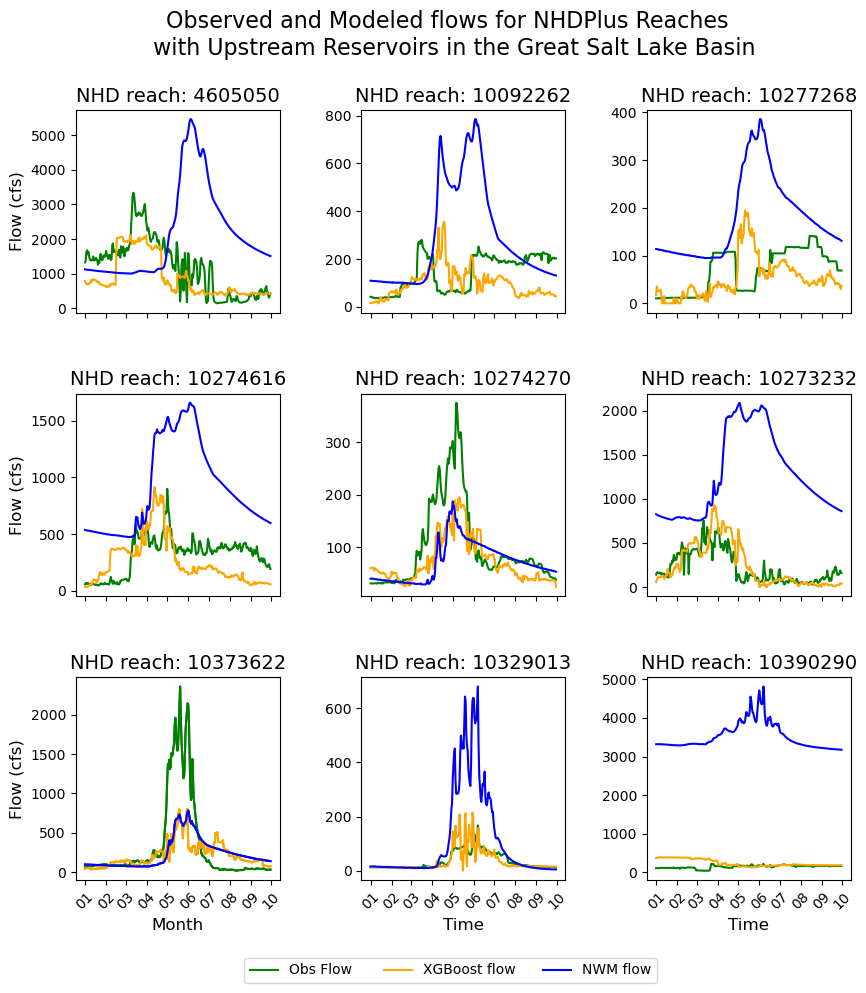

In [139]:
model = 'XGBoost'
plotname = 'XGBoost_TS_plot'
freq = 'D'
supply = False
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
FigureGenerator.TS_plot(SitesDict, model, plotname, title, freq, supply)

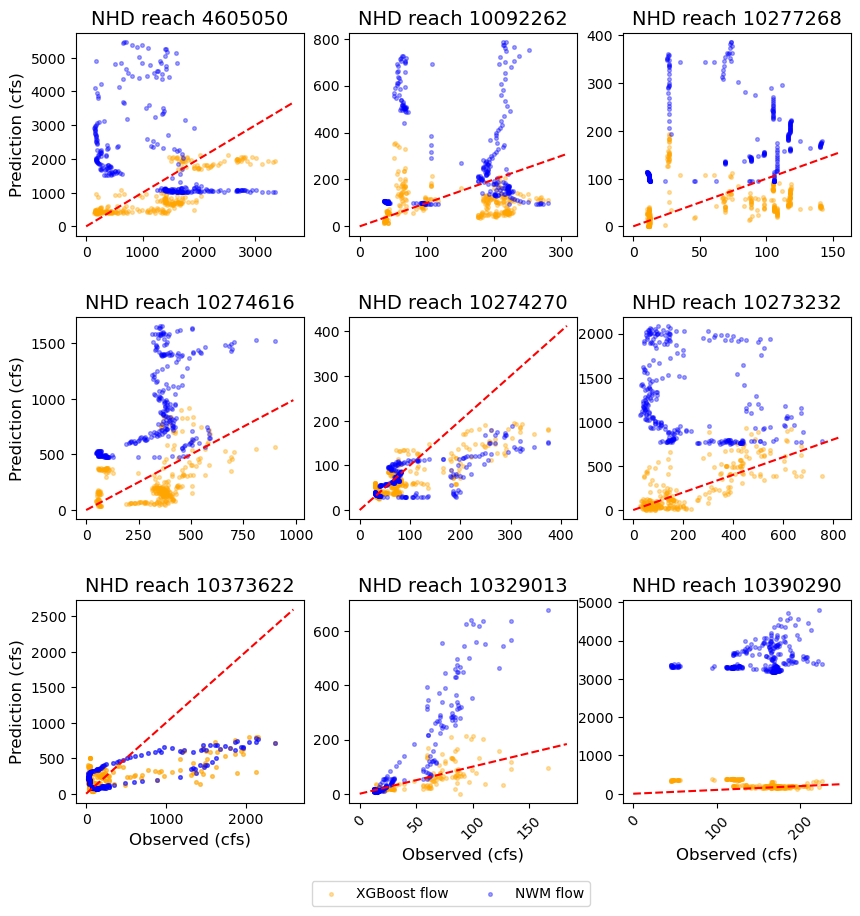

In [126]:
plotname = 'XGBoost_ParityPlot'
FigureGenerator.Parity_plot(SitesDict, model, plotname)

In [1]:
import AWS_transfer
model = 'XGBoost'
state = 'ut'
AWS_transfer.Predictions2AWS(model, state)

Pushing files to AWS


100% |########################################################################|


In [4]:
reach = 10273232
variables =['NWM_flow', 'Obs_flow']
colors = ['blue', 'green']
model = 'XGBoost'
plotname = 'NWMFlow'
units = 'cfs'
y_lab = f"Flow ({units})"
title = f"Daily NWM Estimates \n Reach: {str(reach)}"


FigureGenerator.Var_TS_plot(SitesDict, reach, variables, colors, model,y_lab, plotname, title, units, supply = False)

NameError: name 'FigureGenerator' is not defined